In [1]:
# ============================================================
# 1. Import Library
# ============================================================
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import joblib
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer


In [2]:
# ============================================================
# 2. Load Data (aman untuk file besar)
# ============================================================
# Ambil sample acak 50k review dari review.json (soalnya file nyampe 4GB+)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
SAMPLE_SIZE = 50000
np.random.seed(42)


sample = []
with open("review.json", "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i < SAMPLE_SIZE:
            sample.append(line)
        else:
            j = np.random.randint(0, i+1)
            if j < SAMPLE_SIZE:
                sample[j] = line

df = pd.read_json("".join(sample), lines=True)

print("✅ Cek Missing Value:", df.isnull().sum())
print("✅ Data loaded. Shape:", df.shape)
print(df.head())

C:\Users\HYPE AMD\AppData\Local\Temp\ipykernel_17540\3291974538.py:21: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json("".join(sample), lines=True)


✅ Cek Missing Value: review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64
✅ Data loaded. Shape: (50000, 9)
                review_id                 user_id             business_id  \
0  X1TjCDTI89_OKTz24-rFAw  6OZ6x1W4Jr0plzjZJIu1PA  ZRSVqYaoo3VMvthb2QEJmw   
1  mLstmZM_MuaezxtVEBDSdQ  SPh-RZN8FnZDLJmCcYmXNA  VaO-VW3e1kARkU9bP1E7Fw   
2  OAV0YmF9iXGfR6Q5v0QtCQ  ePDm9AEM-Rhu1p6yHTs3bg  mll4kf6HUHOu5AThf0GJYQ   
3  GvV6XEn_V_Dz9s4cRkCJzw  HvEfnmFatfuRHjcbc_oMVg  hI0GTJb4tzPaablp77E0Gg   
4  w_tLLgj7YJrf1AjziG7frA  KWIkSxfKuX1zMHiu8il0qQ  YMOCOlONOae4zaiKImTnTQ   

   stars  useful  funny  cool  \
0      4       3      1     1   
1      3       0      0     0   
2      1       0      1     0   
3      2       0      0     0   
4      1       0      0     0   

                                                text                date  
0  Reading a review with laughter from a yo

In [3]:
# ============================================================
# 3. Kolom Penting
# ============================================================
df = df[["text", "stars"]]

# ============================================================
# 4. Label Sentimen
# ============================================================
def to_sentiment(stars):
    if stars >= 4:
        return "positive"
    elif stars <= 2:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["stars"].apply(to_sentiment)
print(df["sentiment"].value_counts())

sentiment
positive    33343
negative    11621
neutral      5036
Name: count, dtype: int64


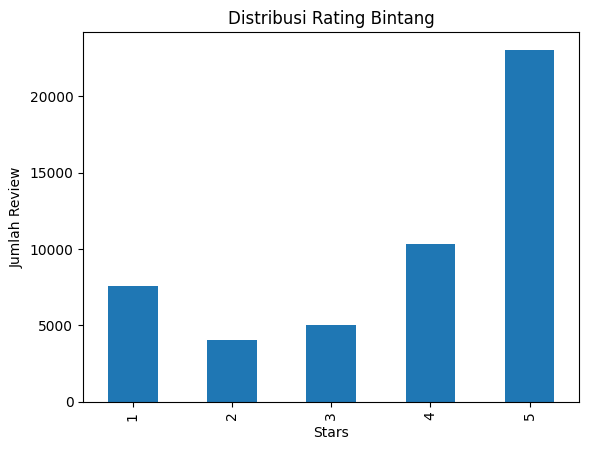

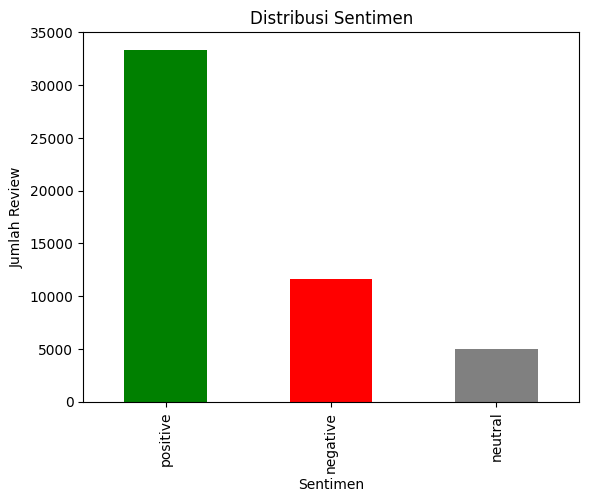

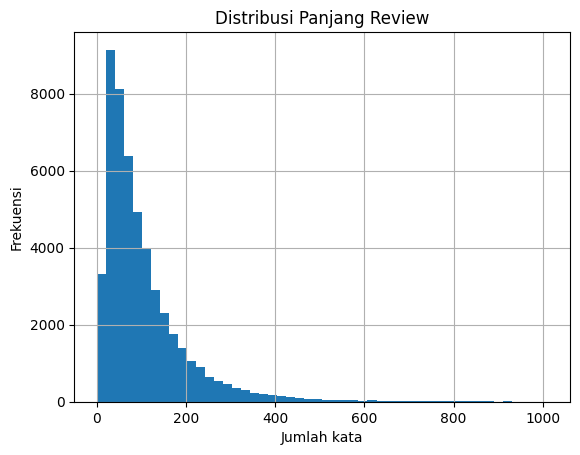

In [4]:
# ============================================================
# 5. EDA (Exploratory Data Analysis)
# ============================================================
# Distribusi rating
df["stars"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribusi Rating Bintang")
plt.xlabel("Stars")
plt.ylabel("Jumlah Review")
plt.show()

# Distribusi sentimen
df["sentiment"].value_counts().plot(kind="bar", color=["green","red","gray"])
plt.title("Distribusi Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

# Panjang review
df["review_length"] = df["text"].apply(lambda x: len(x.split()))
df["review_length"].hist(bins=50)
plt.title("Distribusi Panjang Review")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()


In [5]:
# ============================================================
# 6. Preprocessing
# ============================================================
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    words = nltk.word_tokenize(text.lower())
    words = [w for w in words if w not in stop_words and len(w) > 2]
    pos_tags = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(w, get_wordnet_pos(tag)) for w, tag in pos_tags]
    return " ".join(words)


def top_words(sentiment_label, n=10):
    words = " ".join(df[df["sentiment"]==sentiment_label]["clean_text"]).split()
    return Counter(words).most_common(n)

df["clean_text"] = df["text"].apply(clean_text)
print("Top words POSITIVE:", top_words("positive"))
print("Top words NEGATIVE:", top_words("negative"))


Top words POSITIVE: [('great', 18558), ('place', 16999), ('good', 16593), ('food', 15894), ('get', 15633), ('time', 11653), ('service', 10023), ('come', 9891), ('make', 9398), ('like', 9112)]
Top words NEGATIVE: [('get', 9361), ('food', 6589), ('order', 6404), ('time', 6393), ('place', 5772), ('say', 5743), ('would', 5491), ('come', 5474), ('one', 5351), ('go', 5185)]


In [6]:
# ============================================================
# 7. Split Data
# ============================================================
X = df["clean_text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# 8. Vectorization (TF-IDF)
# ============================================================
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# ============================================================
# 9. Modeling (Logistic Regression)
# ============================================================
model = LogisticRegression(max_iter=2000, class_weight="balanced")
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


✅ Akurasi: 0.8268

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.83      0.82      2324
     neutral       0.37      0.57      0.45      1007
    positive       0.95      0.87      0.91      6669

    accuracy                           0.83     10000
   macro avg       0.71      0.75      0.72     10000
weighted avg       0.86      0.83      0.84     10000



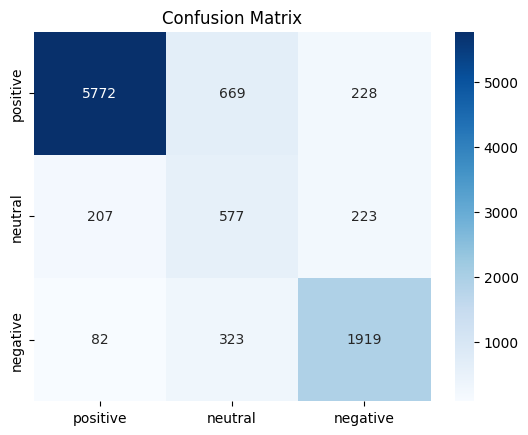

Top kata untuk kelas negative: ['poor' 'two star' 'awful' 'waste' 'disgust' 'money' 'bad' 'rude'
 'horrible' 'terrible']
Top kata untuk kelas neutral: ['though' 'lack' 'bit' 'good' 'aok' 'decent' 'okay' 'three star' 'however'
 'average']
Top kata untuk kelas positive: ['definitely' 'fantastic' 'perfect' 'excellent' 'awesome' 'best' 'love'
 'amaze' 'great' 'delicious']


In [7]:
# ============================================================
# 10. Evaluasi
# ============================================================
y_pred = model.predict(X_test_tfidf)

print("✅ Akurasi:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=["positive","neutral","negative"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive","neutral","negative"],
            yticklabels=["positive","neutral","negative"])
plt.title("Confusion Matrix")
plt.show()

# ============================================================
# 11. Interpretasi (Top Features per Sentiment)
# ============================================================
feature_names = np.array(vectorizer.get_feature_names_out())
for i, label in enumerate(model.classes_):
    top10 = np.argsort(model.coef_[i])[-10:]
    print(f"Top kata untuk kelas {label}:", feature_names[top10])


In [8]:
# ============================================================
# 12. Simpan Model
# ============================================================
joblib.dump(model, "yelp_sentiment_model.joblib")
joblib.dump(vectorizer, "yelp_tfidf_vectorizer.joblib")

# ============================================================
# 13. Chatbot Responder
# ============================================================
def chatbot_response(text, model=model, vectorizer=vectorizer):
    text_clean = clean_text(text)
    text_vec = vectorizer.transform([text_clean])
    sentiment = model.predict(text_vec)[0]

    if sentiment == "positive":
        return "Terima kasih atas ulasannya! Senang mendengar pengalaman positif Anda 😊"
    elif sentiment == "negative":
        return "Mohon maaf atas pengalaman yang mengecewakan. Kami akan menindaklanjuti dan berusaha memperbaiki."
    else:
        return "Terima kasih atas masukan Anda. Kami akan pertimbangkan untuk meningkatkan layanan kami."

# ============================================================
# 14. Test Chatbot
# ============================================================
print(chatbot_response("The food was amazing and the service was great!"))
print(chatbot_response("The food was terrible and the service was slow."))
print(chatbot_response("The restaurant was okay, nothing special."))


Terima kasih atas ulasannya! Senang mendengar pengalaman positif Anda 😊
Mohon maaf atas pengalaman yang mengecewakan. Kami akan menindaklanjuti dan berusaha memperbaiki.
Terima kasih atas masukan Anda. Kami akan pertimbangkan untuk meningkatkan layanan kami.


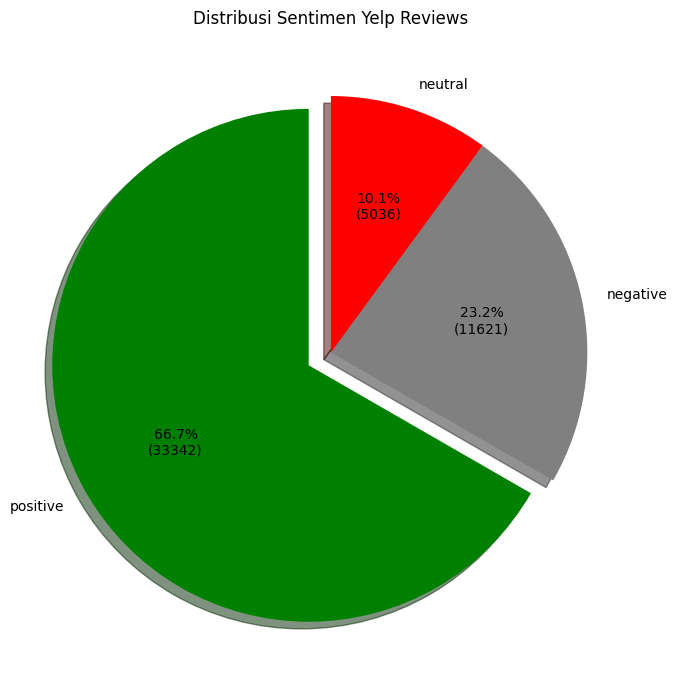

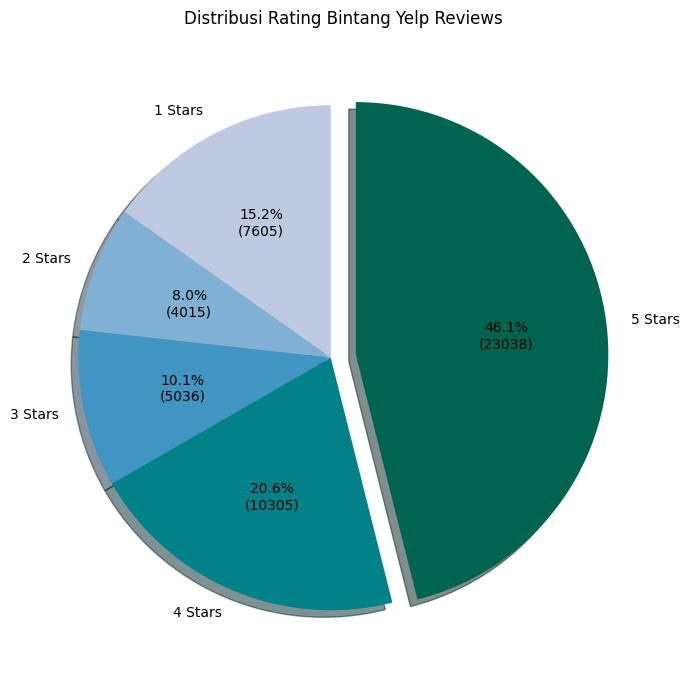

In [9]:
# ============================================================
# 15.Pie Chart Distribusi Sentimen
# ============================================================
sentiment_counts = df["sentiment"].value_counts()
labels = sentiment_counts.index.tolist()
sizes = sentiment_counts.values.tolist()

# "positive" agak keluar
explode = [0.1 if label == "positive" else 0 for label in labels]

plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100)})',
    startangle=90,
    colors=["green", "gray", "red"],
    explode=explode,
    shadow=True
)
plt.title("Distribusi Sentimen Yelp Reviews")
plt.tight_layout()
plt.show()


# Pie Chart Rating Bintang 
stars_counts = df["stars"].value_counts().sort_index()
labels = [f"{star} Stars" for star in stars_counts.index]
sizes = stars_counts.values

# Cari index dengan jumlah terbanyak
max_index = np.argmax(sizes)
explode = [0.1 if i == max_index else 0 for i in range(len(sizes))]

colors = plt.cm.PuBuGn(np.linspace(0.3, 0.9, len(labels)))

plt.figure(figsize=(7,7))
plt.pie(
    sizes,
    labels=labels,
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100)})',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True
)
plt.title("Distribusi Rating Bintang Yelp Reviews")
plt.axis("equal")
plt.tight_layout()
plt.show()

In [10]:
df.head(10)

,text,stars,sentiment,review_length,clean_text
0,Reading a review with laughter from a young gu...,4,positive,178,read review laughter young guy stick nyc thats...
1,"We ordered a cup of gumbo, a cup of jambalaya ...",3,neutral,92,ordered cup gumbo cup jambalaya cup etouffee r...
2,Took me a bit before I decided to write this r...,1,negative,163,take bit decide write review place piss dude n...
3,I came here 6 months ago and had a great exper...,2,negative,70,come month ago great experience past week end ...
4,If I could give it no stars I would it took an...,1,negative,77,could give star would take hour get seat get m...
5,I went yesterday with my boyfriend with the in...,3,neutral,159,go yesterday boyfriend intention try hummus ch...
6,I have a love/hate thing with Mixto. On the l...,3,neutral,228,lovehate thing mixto love side food brunch din...
7,This place has great food and the portions are...,4,positive,52,place great food portion huge service little s...
8,The service was excellent at the Brewhouse. Ou...,3,neutral,159,service excellent brewhouse server prompt poli...
9,"I am from Atlanta, and on a recent trip to Buc...",5,positive,73,atlanta recent trip buck county decide stop ta...


[nltk_data] Downloading package stopwords to C:\Users\HYPE
[nltk_data]     AMD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Kata terbanyak di review negatif:
[('would', 5491), ('get', 5181), ('one', 5138), ('time', 4982), ('service', 4939), ('back', 4877), ('like', 4608), ('good', 4012), ('never', 3467), ('even', 3414), ('said', 3406), ('dont', 3345), ('told', 3319), ('didnt', 3167), ('order', 3166), ('got', 3116), ('ordered', 2754), ('could', 2712), ('came', 2688), ('went', 2591)]

Kata terbanyak di review positif:
[('great', 18448), ('good', 15470), ('service', 9643), ('time', 9367), ('one', 8460), ('get', 8292), ('like', 8263), ('back', 8135), ('really', 7454), ('also', 7451), ('best', 7097), ('would', 6726), ('delicious', 6511), ('love', 6212), ('nice', 6184), ('always', 6130), ('friendly', 6128), ('well', 5961), ('staff', 5763), ('amazing', 5673)]


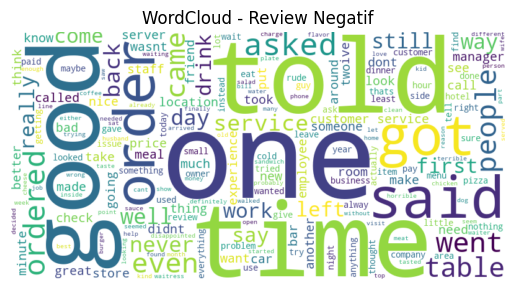

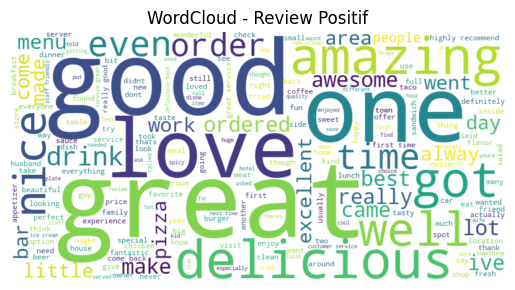

In [13]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords NLTK (cukup sekali aja)
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Tambah stopwords custom kalau perlu
extra_stopwords = {"food", "place", "restaurant"}  # kata umum di Yelp yg terlalu sering muncul
stop_words = stop_words.union(extra_stopwords)

# Fungsi clean text
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))  # hapus non-alfabet
    words = text.lower().split()
    words = [w for w in words if w not in stop_words and len(w) > 2]  # buang stopwords & kata pendek
    return " ".join(words)

df["clean_text"] = df["text"].apply(clean_text)

# Pisahin review negatif & positif
neg_text = " ".join(df[df["stars"] <= 2]["clean_text"])
pos_text = " ".join(df[df["stars"] >= 4]["clean_text"])

# Hitung kata terbanyak
neg_words = Counter(neg_text.split()).most_common(20)
pos_words = Counter(pos_text.split()).most_common(20)

print("Kata terbanyak di review negatif:")
print(neg_words)

print("\nKata terbanyak di review positif:")
print(pos_words)



from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud untuk review negatif
wc_neg = WordCloud(width=800, height=400, background_color="white").generate(neg_text)
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Review Negatif")
plt.show()

# WordCloud untuk review positif
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Review Positif")
plt.show()



                                                text  stars sentiment  \
0  Reading a review with laughter from a young gu...      4  positive   
1  We ordered a cup of gumbo, a cup of jambalaya ...      3   neutral   
2  Took me a bit before I decided to write this r...      1  negative   
3  I came here 6 months ago and had a great exper...      2  negative   
4  If I could give it no stars I would it took an...      1  negative   

   review_length                                         clean_text  
0            178  reading review laughter young guy stuck nyc th...  
1             92  ordered cup gumbo cup jambalaya cup etouffee r...  
2            163  took bit decided write review pissed dude nail...  
3             70  came months ago great experience past week end...  
4             77  could give stars would took hour get seated ge...  

===== Logistic Regression =====
Accuracy: 0.8626
Classification Report:
               precision    recall  f1-score   support

    negative

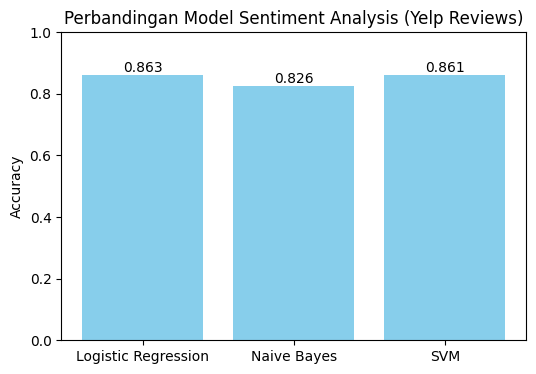

In [14]:
# ============================================================
# Import Library
# ============================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

print(df.head())

# 3. TF-IDF Vectorizer
# ============================================================
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Model Candidates
# ============================================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

# 5. Training & Evaluation
# ============================================================
results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    results[name] = acc
    
# 6. Summary Akurasi (Visualisasi)
# ============================================================
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color="skyblue")
plt.ylabel("Accuracy")
plt.title("Perbandingan Model Sentiment Analysis (Yelp Reviews)")
plt.ylim(0,1)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")
plt.show()
